<a href="https://colab.research.google.com/github/ashishpatel26/Covid19-Models/blob/master/Covid19_MutliModel_Approach_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 1.x
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2
from tqdm import notebook
from sklearn.model_selection import StratifiedShuffleSplit
import warnings 
warnings.filterwarnings("ignore")

from tensorflow.keras import optimizers
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import *
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.vgg19 import *
from tensorflow.keras.applications import vgg19
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.utils.data_utils import Sequence
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# from keras.utils import Sequence

In [0]:
# import matplotlib.pyplot as plt
# def plot_for_class(label):
#     nb_rows = 2
#     nb_cols = 2
#     fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

#     n = 0
#     for i in range(0, nb_rows):
#         for j in range(0, nb_cols):
#             axs[i, j].xaxis.set_ticklabels([])
#             axs[i, j].yaxis.set_ticklabels([])
#             axs[i, j].imshow(images_per_class[label][n])
#             n += 1
#     plt.show()

In [0]:
train = '/content/drive/My Drive/dataset/train/'
test = '/content/drive/My Drive/dataset/test/'

In [0]:
class DataLoader():
  def __init__(self, path, dim = 224):
    self.path = path
    self.dim = dim

  def preprocessing(self,instancePath, preprocessing_input = vgg19.preprocess_input):
    image = load_img(instancePath, target_size=(self.dim, self.dim))
    image = img_to_array(image)
    image /= 255.0
    image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image

  def prepare_train_data(self):
    X_train = []
    y_train = []
    for class_folder_name in os.listdir(self.path):
      class_folder_path = os.path.join(self.path, class_folder_name)
      for img in notebook.tqdm(os.listdir(class_folder_path)):
        imgpath = os.path.join(class_folder_path, img)
        img = self.preprocessing(imgpath)
        X_train.append(img)
        y_train.append(1 if class_folder_name == 'corona' else 0)
    
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    print(f'X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}')
    return X_train,y_train

In [16]:
dl = DataLoader(path = train, dim = 300)
X_train, y_train = dl.prepare_train_data()


X_train shape:(178, 300, 300, 3)
Y_train shape:(178,)


In [0]:
import numpy as np
np.save('/content/drive/My Drive/X_train.npy', X_train)
np.save('/content/drive/My Drive/y_train.npy', y_train)

In [18]:
print(f'X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}')
#X_train = np.load('/content/drive/My Drive/EfficientNet/X_train.npy')
#y_train = np.load('/content/drive/My Drive/EfficientNet/y_train.npy')

X_train shape:(178, 300, 300, 3)
Y_train shape:(178,)


In [19]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
print(f'X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}')

X_train shape:(178, 300, 300, 3)
Y_train shape:(178, 2)


In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.16, random_state=42) # Want a balanced split for all the classes
# for train_index, test_index in sss.split(x_train, y_train):
#     print("Using {} for training and {} for validation".format(len(train_index), len(test_index)))
#     x_train, x_valid = x_train[train_index], x_train[test_index]
#     y_train, y_valid = y_train[train_index], y_train[test_index]


print(f'X_train shape:{x_train.shape}\nY_train shape:{y_train.shape}\nX_valid shape:{x_valid.shape}\nY_valid shape:{y_valid.shape}')

X_train shape:(160, 300, 300, 3)
Y_train shape:(160, 2)
X_valid shape:(18, 300, 300, 3)
Y_valid shape:(18, 2)


In [0]:
dim = 300

In [0]:
epochs = 10
learning_rate = 0.0001
batch_size = 32
weights="/content/drive/My Drive/weight_augment.h5"

In [0]:
callbacks = [ EarlyStopping(monitor='val_loss', patience=15, verbose=0), 
              ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,verbose=0, mode='auto')]

In [39]:
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *


vgg=keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(dim,dim,3))
resnet=keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(dim,dim,3))


for layer in vgg.layers:
  layer.trainable = False
for layer in resnet.layers:
  layer.trainable = False
  
  
resnet_out = resnet.output
resnet_final=GlobalAveragePooling2D()(resnet_out)
vgg_out = vgg.output
vgg_final=GlobalAveragePooling2D()(vgg_out)


pre_combined_model = Concatenate()([resnet_final, vgg_final])


premodel= Dense(512,activation='relu')(pre_combined_model)
premodel1= Dense(2,activation='softmax')(premodel)

finalmodel=Model(inputs=[vgg.input,resnet.input],outputs=[premodel1])
finalmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
# model.load_weights('/content/drive/My Drive/dataset/Best Model/Mobilenet2.h5')
finalmodel.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])

In [50]:
history=finalmodel.fit([x_train, x_train], y_train, epochs=10, batch_size=32, validation_data=([x_valid,x_valid], y_valid), verbose=1, callbacks=callbacks, use_multiprocessing=True)
# history = finalmodel.fit([x_train,x_train] , y_train, batch_size=32,epochs=10,validation_data=(x_valid, y_valid),verbose=1, callbacks=callbacks, use_multiprocessing=True)

Train on 160 samples, validate on 18 samples
Epoch 1/10
160/160 [==============================] - 10s 62ms/sample - loss: 6.2739 - acc: 0.5938 - val_loss: 7.6685 - val_acc: 0.5000
Epoch 2/10
160/160 [==============================] - 6s 34ms/sample - loss: 7.6895 - acc: 0.5000 - val_loss: 7.6685 - val_acc: 0.5000
Epoch 3/10
160/160 [==============================] - 6s 34ms/sample - loss: 7.6895 - acc: 0.5000 - val_loss: 7.6685 - val_acc: 0.5000
Epoch 4/10
160/160 [==============================] - 6s 34ms/sample - loss: 7.6895 - acc: 0.5000 - val_loss: 7.6685 - val_acc: 0.5000
Epoch 5/10
160/160 [==============================] - 6s 34ms/sample - loss: 7.6895 - acc: 0.5000 - val_loss: 7.6685 - val_acc: 0.5000
Epoch 6/10
160/160 [==============================] - 6s 35ms/sample - loss: 7.6895 - acc: 0.5000 - val_loss: 7.6685 - val_acc: 0.5000
Epoch 7/10
160/160 [==============================] - 6s 35ms/sample - loss: 7.6895 - acc: 0.5000 - val_loss: 7.6685 - val_acc: 0.5000
Epoch 8/1

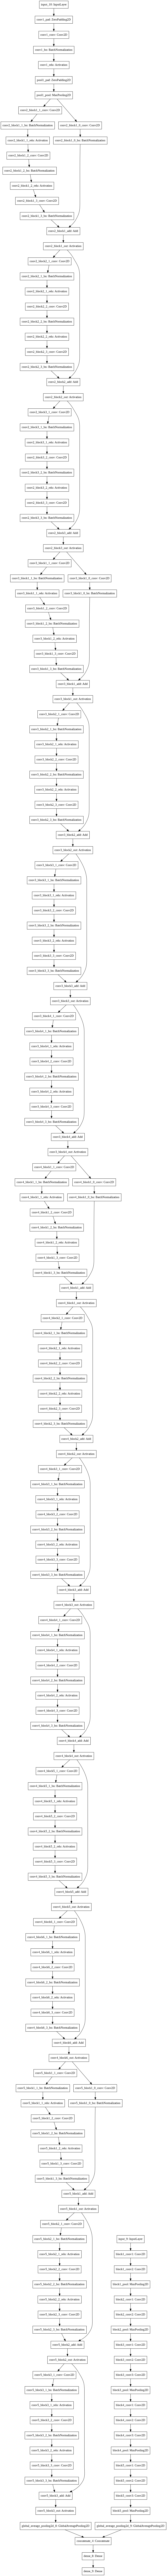

In [51]:
import tensorflow as tf

tf.keras.utils.plot_model(
    finalmodel, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [52]:
import pandas as pd
result = pd.DataFrame(history.history)
result

,loss,acc,val_loss,val_acc,lr
0,6.273909,0.59375,7.668547,0.5,0.001
1,7.689546,0.50000,7.668547,0.5,0.001
2,7.689547,0.50000,7.668547,0.5,0.001
3,7.689546,0.50000,7.668547,0.5,0.001
4,7.689547,0.50000,7.668547,0.5,0.001
5,7.689546,0.50000,7.668547,0.5,0.001
6,7.689546,0.50000,7.668547,0.5,0.001
7,7.689547,0.50000,7.668547,0.5,0.001
8,7.689546,0.50000,7.668547,0.5,0.001
9,7.689547,0.50000,7.668547,0.5,0.001


No handles with labels found to put in legend.


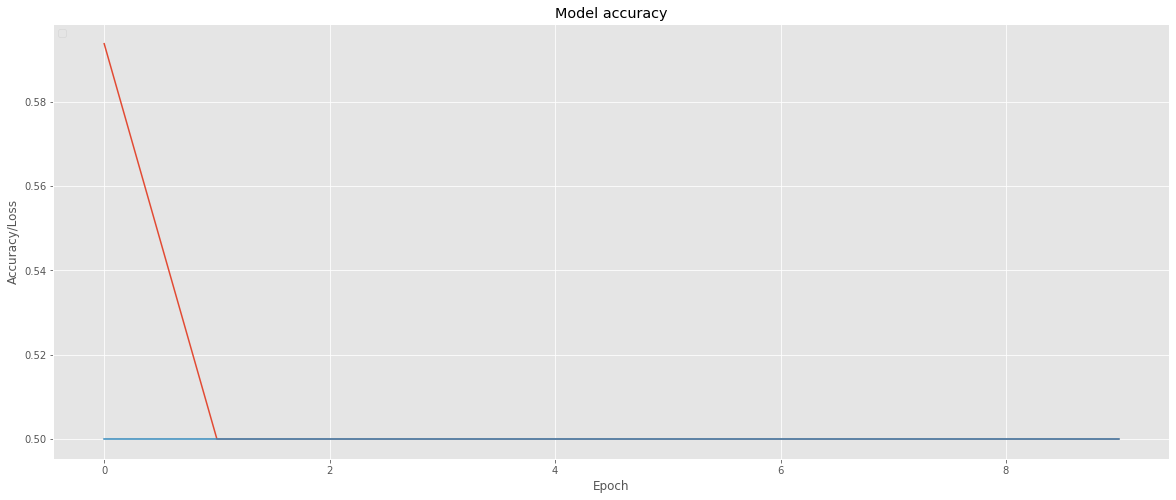

No handles with labels found to put in legend.


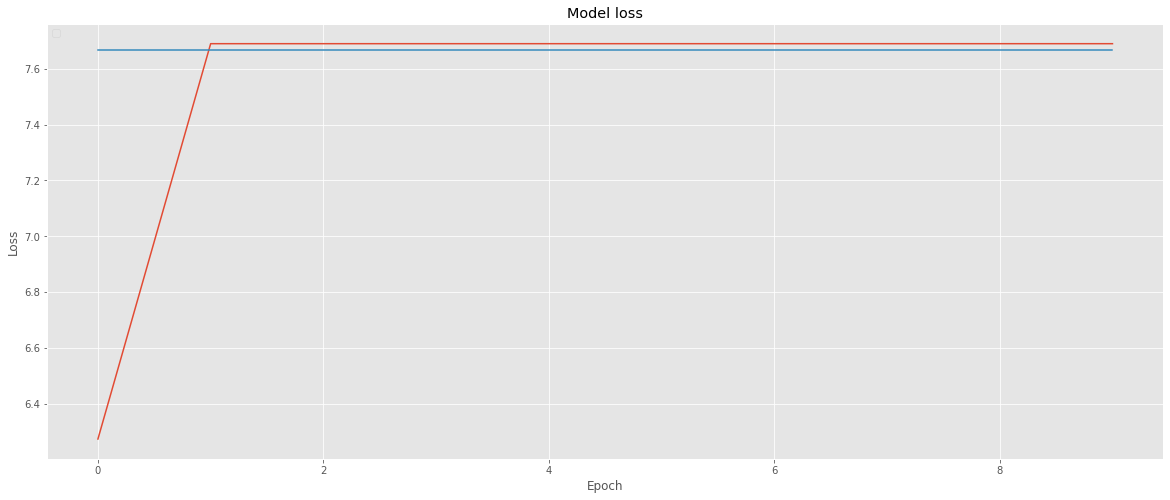

In [63]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') 

# Plot training & validation accuracy values
plt.figure(figsize=(20,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [58]:
#saving the model
fer_json = finalmodel.to_json()
with open("/content/drive/My Drive/fer.json", "w") as json_file:
  json_file.write(fer_json)
finalmodel.save_weights("/content/drive/My Drive/fer.h5")
print("Saved Model to Disk")

Saved Model to Disk


In [67]:
score = finalmodel.evaluate([x_valid,x_valid], y_valid, verbose=1)

print(f'Val_loss : {score[0]}\nVal_Acc: {score[1]}')

18/18 [==============================] - 1s 43ms/sample - loss: 7.6685 - acc: 0.5000
Val_loss : 7.668546676635742
Val_Acc: 0.5


In [0]:
y_pred = np.argmax(finalmodel.predict([x_valid,x_valid]), axis=1)
y_valid = np.argmax(y_valid, axis=1)

In [72]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(y_valid, y_pred))
print('Classification Report')
target_names = ['pnumonia','corona']
print(classification_report(y_valid, y_pred, target_names=target_names))

Confusion Matrix
[[9 0]
 [9 0]]
Classification Report
              precision    recall  f1-score   support

    pnumonia       0.50      1.00      0.67         9
      corona       0.00      0.00      0.00         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18



Text(33.0, 0.5, "('pnumonia', 'corona')")

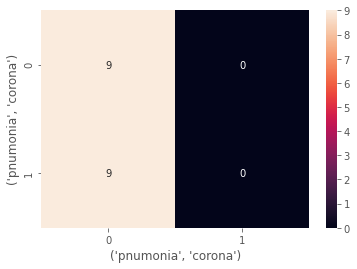

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

ax = sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, fmt="d")
ax.set_xlabel(tuple(target_names))
ax.set_ylabel(tuple(target_names))